# Simple Neural Network Music Genre Classification:

This notebook is dedicated to improving the test accuracy of the network presented in:
https://www.kaggle.com/code/aasimahmed04/music-genre-classifier

A variation on the CNN Presented in https://www.kaggle.com/code/farzadnekouei/cifar-10-image-classification-with-cnn

In [1]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
import tensorflow.keras as keras
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import librosa, IPython
import librosa.display as lplt

from sklearn.metrics import accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from keras import regularizers

import IPython.display as ipd
from IPython.display import Audio

### Labels are base on the following mapping:

In [2]:
map_ = {
    "blues"     : 0,
    "classical" : 1,
    "country"   : 2,
    "disco"     : 3,
    "hiphop"    : 4,
    "jazz"      : 5,
    "metal"     : 6,
    "pop"       : 7,
    "reggae"    : 8,
    "rock"      : 9,
}

### Load Data

In [3]:
csv_file_path = 'features_30_sec.csv'

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

In [4]:
# Separate features (X) and labels (y)
X_ = df.drop(columns=['label','filename','length','rms_var']).values  # Drop the 'label' column to get features
y_ = df['label']  # Get the 'label' column for labels

In [5]:
X_.shape

(1000, 56)

In [6]:
X = X_[...,np.newaxis]
y = np.array([map_[label_] for label_ in y_])

In [7]:
# Convert to appropriate data types
X = X.astype(np.float32)
y = y.astype(np.int32)

In [8]:
# Split into training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,shuffle=True)

In [9]:
print("Train data size: ", X_train.shape);
print("Validation data size: ",X_val.shape);
print("Test data size: ", X_test.shape);

Train data size:  (680, 56, 1)
Validation data size:  (170, 56, 1)
Test data size:  (150, 56, 1)


In [10]:
input_shape_ = (X_train.shape[1], X_train.shape[2])
print(input_shape_)

(56, 1)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras import regularizers

# Initialize a sequential model
model = Sequential()

# Set the weight decay value for L2 regularization
weight_decay = 0.0001

# Define the input shape of the vector (e.g., if vector length is 100, input_shape = (100,))
input_shape = (100,)  # Modify based on your vector's length

# Add the first 1D convolutional layer with 32 filters of size 3
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay), 
                 input_shape=input_shape_))
# Add batch normalization layer
model.add(BatchNormalization())

# Add the second 1D convolutional layer similar to the first
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())

# Add the first max pooling layer with pool size of 2
model.add(MaxPooling1D(pool_size=2, padding='same'))
# Add dropout layer with 0.2 dropout rate
model.add(Dropout(rate=0.2))

# Add the third and fourth 1D convolutional layers with 64 filters
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))   
model.add(BatchNormalization())
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())

# Add the second max pooling layer and increase dropout rate to 0.3
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(rate=0.3))

# Add the fifth and sixth 1D convolutional layers with 128 filters
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay))) 
model.add(BatchNormalization())
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(BatchNormalization())

# Add the third max pooling layer and increase dropout rate to 0.4
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(rate=0.4))

# Flatten the tensor output from the previous layer
model.add(Flatten())

# Add Layers to classifier

model.add(Dense(16,kernel_regularizer=regularizers.l2(0.0005), activation='relu')) 
model.add(Dropout(0.3))  

# Add a fully connected layer with softmax activation function for outputting class probabilities
model.add(Dense(10, activation='softmax'))


C:\Users\420\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 56, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 56, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 56, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 56, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 28, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 28, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 28, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 28, 64)              │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 28, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 14, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 14, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 14, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 112,090 (437.85 KB)

 Trainable params: 111,194 (434.35 KB)

 Non-trainable params: 896 (3.50 KB)

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=300, validation_data=(X_val, y_val), batch_size=32)

Epoch 1/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.1332 - loss: 2.8755 - val_accuracy: 0.2059 - val_loss: 2.2823
Epoch 2/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1848 - loss: 2.2831 - val_accuracy: 0.2176 - val_loss: 2.2204
Epoch 3/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2602 - loss: 2.1735 - val_accuracy: 0.2294 - val_loss: 2.2202
Epoch 4/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2626 - loss: 2.1707 - val_accuracy: 0.2588 - val_loss: 2.1737
Epoch 5/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2404 - loss: 2.1610 - val_accuracy: 0.2294 - val_loss: 2.1340
Epoch 6/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2214 - loss: 2.1151 - val_accuracy: 0.2882 - val_loss: 2.0858
Epoch 7/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2658 - loss: 2.0597 - val_accuracy: 0.1000 - val_loss: 19.6727
Epoch 8/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2262 - loss: 2.1146 - val_accuracy: 0

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3425 - loss: 1.7278 - val_accuracy: 0.4588 - val_loss: 1.5799
Epoch 52/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4062 - loss: 1.6588 - val_accuracy: 0.4000 - val_loss: 1.6398
Epoch 53/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4040 - loss: 1.6306 - val_accuracy: 0.3647 - val_loss: 1.7027
Epoch 54/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4016 - loss: 1.6583 - val_accuracy: 0.4294 - val_loss: 1.5770
Epoch 55/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3912 - loss: 1.6174 - val_accuracy: 0.3706 - val_loss: 1.6044
Epoch 56/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3990 - loss: 1.6441 - val_accuracy: 0.3294 - val_loss: 1.8156
Epoch 57/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3839 - loss: 1.6423 - val_accuracy: 0.4000 - val_loss: 1.6497
Epoch 58/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3516 - loss: 1.7451 - val_accuracy: 0.3412 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5009 - loss: 1.3680 - val_accuracy: 0.4706 - val_loss: 1.5565
Epoch 102/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4918 - loss: 1.3992 - val_accuracy: 0.4882 - val_loss: 1.5502
Epoch 103/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4744 - loss: 1.3992 - val_accuracy: 0.4706 - val_loss: 1.6110
Epoch 104/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5389 - loss: 1.3924 - val_accuracy: 0.4294 - val_loss: 1.5958
Epoch 105/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5369 - loss: 1.3155 - val_accuracy: 0.5000 - val_loss: 1.5413
Epoch 106/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5222 - loss: 1.3615 - val_accuracy: 0.4941 - val_loss: 1.6102
Epoch 107/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4555 - loss: 1.4197 - val_accuracy: 0.5000 - val_loss: 1.5591
Epoch 108/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4960 - loss: 1.3459 - val_accuracy: 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6013 - loss: 1.1644 - val_accuracy: 0.5118 - val_loss: 1.4672
Epoch 152/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5768 - loss: 1.1983 - val_accuracy: 0.4882 - val_loss: 1.4846
Epoch 153/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.6064 - loss: 1.1259 - val_accuracy: 0.5059 - val_loss: 1.4623
Epoch 154/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5928 - loss: 1.1695 - val_accuracy: 0.5000 - val_loss: 1.4805
Epoch 155/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5872 - loss: 1.1717 - val_accuracy: 0.5000 - val_loss: 1.5656
Epoch 156/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5503 - loss: 1.1791 - val_accuracy: 0.5118 - val_loss: 1.5865
Epoch 157/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5638 - loss: 1.2643 - val_accuracy: 0.5000 - val_loss: 1.5535
Epoch 158/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5482 - loss: 1.2490 - val_accuracy: 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6139 - loss: 1.0747 - val_accuracy: 0.5000 - val_loss: 1.6195
Epoch 202/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6097 - loss: 1.0412 - val_accuracy: 0.4941 - val_loss: 1.5869
Epoch 203/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6358 - loss: 1.0678 - val_accuracy: 0.4824 - val_loss: 1.6414
Epoch 204/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6538 - loss: 0.9890 - val_accuracy: 0.5176 - val_loss: 1.6287
Epoch 205/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6376 - loss: 1.0645 - val_accuracy: 0.5000 - val_loss: 1.6019
Epoch 206/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6748 - loss: 0.9164 - val_accuracy: 0.5118 - val_loss: 1.6727
Epoch 207/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6572 - loss: 0.9766 - val_accuracy: 0.4706 - val_loss: 1.6353
Epoch 208/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6702 - loss: 0.9251 - val_accuracy: 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6774 - loss: 0.9809 - val_accuracy: 0.4941 - val_loss: 1.7027
Epoch 252/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6518 - loss: 0.9724 - val_accuracy: 0.5000 - val_loss: 1.6829
Epoch 253/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6937 - loss: 0.9271 - val_accuracy: 0.4882 - val_loss: 1.6791
Epoch 254/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7249 - loss: 0.8582 - val_accuracy: 0.4941 - val_loss: 1.7100
Epoch 255/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6869 - loss: 0.8938 - val_accuracy: 0.5353 - val_loss: 1.6456
Epoch 256/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6862 - loss: 0.8869 - val_accuracy: 0.5000 - val_loss: 1.6739
Epoch 257/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7055 - loss: 0.9158 - val_accuracy: 0.5176 - val_loss: 1.6954
Epoch 258/300
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6755 - loss: 0.9093 - val_accuracy: 

In [14]:
y_predict = np.argmax(model.predict(X_test),axis=1);

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


In [15]:
acc = np.mean(y_predict == y_test)*100
print("test accuracy = %.2f"%acc, "%");

test accuracy = 52.00 %


#### Confusion Matrix

In [16]:
cm = confusion_matrix(y_test, y_predict);

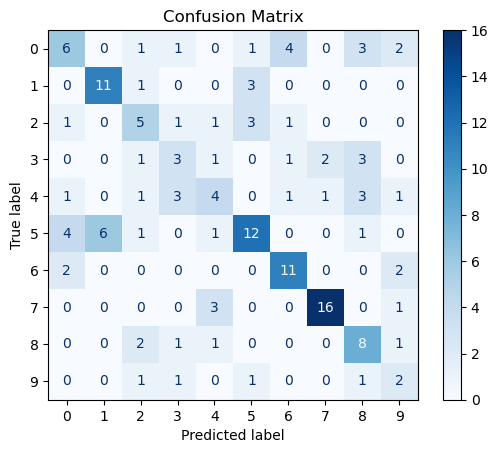

In [17]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")

plt.title('Confusion Matrix')
plt.show()